# LAPAGE

## 0. Nettoyage

* Présentez l'ensemble des choix et actions que vous avez réalisés
* Restitution de l'analyse : les chiffres clés, KPI, graphiques générés, corrélations calculées, ...
* Calcul de l'indicateur de corrélation (R², eta², Chi²) et la mise en place d'un test statistique est nécessaire

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import functions
from time import time
from datetime import datetime

In [2]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
verboseMain = False

print("Chargement des données...")
#C:\Users\User\WORK\workspace-simplon-ia\projets\bottle_neck\1.xlsx
file_path = "C:\\Users\\User\\WORK\\workspace-simplon-ia\\projets\\lapage\\"
file_name_customers = 'customers.csv'
file_name_procuts = 'products.csv'
file_name_transactions = 'transactions.csv'

df_customers = pd.read_csv(file_path+file_name_customers, sep=',')
df_products = pd.read_csv(file_path+file_name_procuts, sep=',')
df_transactions = pd.read_csv(file_path+file_name_transactions, sep=',')

print("Chargement des données", df_customers.shape,df_products.shape,df_transactions.shape, ".... ...................................... END")

Chargement des données...
Chargement des données (8623, 3) (3287, 3) (679532, 4) .... ...................................... END


In [3]:
df_customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [4]:
df_customers["client_id"].nunique()

8623

In [4]:
df_customers = df_customers.drop_duplicates("client_id", keep='first')
df_customers.shape

(8623, 3)

In [6]:
df_products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [7]:
df_products.describe(include="all")

,id_prod,price,categ
count,3287,3287.000000,3287.000000
unique,3287,NaN,NaN
top,0_1421,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.856641,0.370246
std,NaN,29.847908,0.615387
min,NaN,-1.000000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.060000,0.000000
75%,NaN,22.990000,1.000000


Il ne peut pas y avoir de produit avec un prix négatif, supression des produits avec un prix négatif

In [5]:
df_products_clean = df_products[df_products["price"]>=0]
print(df_products.shape, "vs", df_products_clean.shape)

(3287, 3) vs (3286, 3)


In [5]:
df_products_clean["id_prod"].nunique()

3286

In [6]:
df_products_clean.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [6]:
print(df_products_clean.shape, end="")
df_products_clean = df_products_clean.drop_duplicates("id_prod", keep='first')
df_products_clean.shape

(3286, 3)

(3286, 3)

In [12]:
df_transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [8]:
df_transactions.duplicated(subset=['id_prod', 'date', 'session_id', 'client_id']).value_counts()

False    679406
True        126
dtype: int64

Il semble y avoir des doublons dans le fichier de transactions, nous allons zoomer dessus

In [7]:
df_doublon = df_transactions[df_transactions.duplicated(subset=['id_prod', 'date', 'session_id', 'client_id'])]
df_doublon

,id_prod,date,session_id,client_id
27778,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
52424,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
96687,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1
130188,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
139339,T_0,test_2021-03-01 02:30:02.237443,s_0,ct_1
...,...,...,...,...
653098,T_0,test_2021-03-01 02:30:02.237432,s_0,ct_0
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


il semblerait que les produits soient tous "T_0" à voir, peut-être s'agit-il d'un test, la date indiquée semble confirmer qu'il s'agit d'un test.

In [10]:
df_doublon["id_prod"].value_counts()

T_0    126
Name: id_prod, dtype: int64

In [11]:
df_products[df_products["id_prod"]=="T_0"]

,id_prod,price,categ
731,T_0,-1.0,0


In [8]:
df_products[df_products["id_prod"]=="0_2245"]

,id_prod,price,categ


In [9]:
df_transactions_clean = df_transactions[df_transactions["id_prod"]!="T_0"]
print(df_transactions.shape, "vs", df_transactions_clean.shape)

(679532, 4) vs (679332, 4)


In [10]:
df_transactions_clean.duplicated(subset=['id_prod', 'date', 'session_id', 'client_id']).value_counts()

False    679332
dtype: int64

On créé un DF global avec toutes les informations

In [11]:
print(df_transactions_clean.shape, end="")
df_global = df_transactions_clean.merge(df_products_clean, on="id_prod", how='outer', indicator=True)
df_global.shape

(679332, 4)

(679353, 7)

In [12]:
print(df_transactions_clean.shape, end="")
df_global = df_transactions_clean.merge(df_products_clean, on="id_prod", how='outer', indicator=True)
df_global.shape

(679332, 4)

(679353, 7)

In [22]:
df_global.head()

,id_prod,date,session_id,client_id,price,categ,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,both
1,0_1518,2021-09-26 12:37:29.780414,s_95811,c_6197,4.18,0.0,both
2,0_1518,2021-05-06 17:14:43.117440,s_30782,c_682,4.18,0.0,both
3,0_1518,2022-03-16 18:57:10.420103,s_180057,c_5932,4.18,0.0,both
4,0_1518,2022-11-12 18:58:10.574853,s_296584,c_7217,4.18,0.0,both


In [23]:
df_global["_merge"].value_counts()

both          679111
left_only        221
right_only        21
Name: _merge, dtype: int64

In [13]:
not_commons = df_global[df_global["_merge"]!="both"]
not_commons.shape

(242, 7)

In [25]:
not_commons.head()

,id_prod,date,session_id,client_id,price,categ,_merge
542560,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,NaN,NaN,left_only
542561,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,NaN,NaN,left_only
542562,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,NaN,NaN,left_only
542563,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,NaN,NaN,left_only
542564,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,NaN,NaN,left_only


In [26]:
not_commons.isna().sum()

id_prod         0
date           21
session_id     21
client_id      21
price         221
categ         221
_merge          0
dtype: int64

In [14]:
not_commons[not_commons["price"].isna()]

,id_prod,date,session_id,client_id,price,categ,_merge
542560,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,NaN,NaN,left_only
542561,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,NaN,NaN,left_only
542562,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,NaN,NaN,left_only
542563,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,NaN,NaN,left_only
542564,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,NaN,NaN,left_only
...,...,...,...,...,...,...,...
542776,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,NaN,NaN,left_only
542777,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,NaN,NaN,left_only
542778,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,NaN,NaN,left_only
542779,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,NaN,NaN,left_only


In [15]:
not_commons[not_commons["price"].isna()].describe(include="all")

,id_prod,date,session_id,client_id,price,categ,_merge
count,221,221,221,221,0.0,0.0,221
unique,1,221,221,100,NaN,NaN,1
top,0_2245,2022-09-23 07:22:38.636773,s_272266,c_1533,NaN,NaN,left_only
freq,221,1,1,6,NaN,NaN,221
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN


le produit 0_2245 n'apparaît pas dans la base de produit.
Il a pu être sortit de la base ou erreur ?

In [16]:
df_global_clean =  df_global[df_global["id_prod"]!="0_2245"]
df_global_clean.shape

(679132, 7)

In [18]:
not_commons = df_global_clean[df_global_clean["_merge"]!="both"]
not_commons.shape

(21, 7)

In [21]:
not_commons.describe(include="all")

,id_prod,date,session_id,client_id,price,categ,_merge
count,21,0,0,0,21.000000,21.000000,21
unique,21,0,0,0,NaN,NaN,1
top,0_1016,NaN,NaN,NaN,NaN,NaN,right_only
freq,1,NaN,NaN,NaN,NaN,NaN,21
mean,NaN,NaN,NaN,NaN,37.870476,0.380952,NaN
std,NaN,NaN,NaN,NaN,56.619963,0.740013,NaN
min,NaN,NaN,NaN,NaN,0.800000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,2.990000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,22.050000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,31.820000,0.000000,NaN


In [19]:
not_sales_product = not_commons
not_sales_product.head(21)

,id_prod,date,session_id,client_id,price,categ,_merge
679332,0_1016,NaN,NaN,NaN,35.06,0.0,right_only
679333,0_1780,NaN,NaN,NaN,1.67,0.0,right_only
679334,0_1062,NaN,NaN,NaN,20.08,0.0,right_only
679335,0_1119,NaN,NaN,NaN,2.99,0.0,right_only
679336,0_1014,NaN,NaN,NaN,1.15,0.0,right_only
679337,1_0,NaN,NaN,NaN,31.82,1.0,right_only
679338,0_1318,NaN,NaN,NaN,20.92,0.0,right_only
679339,0_1800,NaN,NaN,NaN,22.05,0.0,right_only
679340,0_1645,NaN,NaN,NaN,2.99,0.0,right_only
679341,0_322,NaN,NaN,NaN,2.99,0.0,right_only


In [23]:
print(df_global_clean.shape, "vs", end="")
df_global_clean = df_global_clean[df_global_clean["_merge"]=="both"]
df_global_clean.shape

(679132, 7) vs

(679111, 7)

In [34]:
df_global_clean["_merge"].value_counts()

both          679111
left_only          0
right_only         0
Name: _merge, dtype: int64

In [24]:
df_global_clean1 = df_global_clean[["id_prod","date","session_id","client_id","price","categ"]]
df_global_clean1.head()

,id_prod,date,session_id,client_id,price,categ
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0
1,0_1518,2021-09-26 12:37:29.780414,s_95811,c_6197,4.18,0.0
2,0_1518,2021-05-06 17:14:43.117440,s_30782,c_682,4.18,0.0
3,0_1518,2022-03-16 18:57:10.420103,s_180057,c_5932,4.18,0.0
4,0_1518,2022-11-12 18:58:10.574853,s_296584,c_7217,4.18,0.0


In [36]:
df_customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [25]:
print(df_global_clean1.shape, end="")
# , on="id_prod", how='outer', indicator=True)
df_global_full_merge = df_global_clean1.merge(df_customers, on="client_id", how='outer', indicator=True)
df_global_full_merge.shape

(679111, 6)

(679134, 9)

In [38]:
df_global_full_merge["_merge"].value_counts()

both          679111
right_only        23
left_only          0
Name: _merge, dtype: int64

In [26]:
customers_who_never_buy = df_global_full_merge[df_global_full_merge["_merge"]!="both"]
customers_who_never_buy.head(25)

,id_prod,date,session_id,client_id,price,categ,sex,birth,_merge
679111,NaN,NaN,NaN,c_8253,NaN,NaN,f,2001,right_only
679112,NaN,NaN,NaN,c_3789,NaN,NaN,f,1997,right_only
679113,NaN,NaN,NaN,c_4406,NaN,NaN,f,1998,right_only
679114,NaN,NaN,NaN,ct_0,NaN,NaN,f,2001,right_only
679115,NaN,NaN,NaN,c_2706,NaN,NaN,f,1967,right_only
679116,NaN,NaN,NaN,c_3443,NaN,NaN,m,1959,right_only
679117,NaN,NaN,NaN,c_4447,NaN,NaN,m,1956,right_only
679118,NaN,NaN,NaN,c_3017,NaN,NaN,f,1992,right_only
679119,NaN,NaN,NaN,c_4086,NaN,NaN,f,1992,right_only
679120,NaN,NaN,NaN,c_6930,NaN,NaN,m,2004,right_only


In [40]:
customers_who_never_buy.shape

(23, 9)

In [27]:
print(df_global_full_merge.shape, end="")
df_global_full = df_global_full_merge[df_global_full_merge["_merge"]=="both"]
df_global_full.shape

(679134, 9)

(679111, 9)

In [28]:
df_global_full = df_global_full[["id_prod","date","session_id","client_id","price","categ","sex","birth"]]
df_global_full.shape

(679111, 8)

In [43]:
df_global_full.isna().sum()

id_prod       0
date          0
session_id    0
client_id     0
price         0
categ         0
sex           0
birth         0
dtype: int64

Maintenant que nous avons un DF global nous pouvons nettoyer, organiser et typer les données

In [44]:
df_global_full.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,f,1986
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,4.18,0.0,f,1986
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,4.18,0.0,f,1986
3,0_1418,2022-06-18 01:49:37.823274,s_225411,c_103,8.57,0.0,f,1986
4,0_1418,2021-08-18 01:49:37.823274,s_77214,c_103,8.57,0.0,f,1986


In [45]:
df_global_full.describe(include="all")

,id_prod,date,session_id,client_id,price,categ,sex,birth
count,679111,679111,679111,679111,679111.000000,679111.000000,679111,679111.000000
unique,3265,679111,342275,8600,NaN,NaN,2,NaN
top,1_369,2022-05-20 13:21:29.043970,s_118668,c_1609,NaN,NaN,m,NaN
freq,2252,1,14,25488,NaN,NaN,340826,NaN
mean,NaN,NaN,NaN,NaN,17.454773,0.441953,NaN,1977.811149
std,NaN,NaN,NaN,NaN,18.328998,0.595042,NaN,13.575361
min,NaN,NaN,NaN,NaN,0.620000,0.000000,NaN,1929.000000
25%,NaN,NaN,NaN,NaN,8.870000,0.000000,NaN,1970.000000
50%,NaN,NaN,NaN,NaN,13.990000,0.000000,NaN,1980.000000
75%,NaN,NaN,NaN,NaN,18.990000,1.000000,NaN,1987.000000


In [29]:
# Réorganisation des colonnes suivant un ordre plus fonctionnel
df_global_ordered = df_global_full[["client_id", "sex", "birth","session_id", "date", "id_prod", "categ", "price"]]
df_global_ordered.head()

,client_id,sex,birth,session_id,date,id_prod,categ,price
0,c_103,f,1986,s_211425,2022-05-20 13:21:29.043970,0_1518,0.0,4.18
1,c_103,f,1986,s_64849,2021-07-20 13:21:29.043970,0_1518,0.0,4.18
2,c_103,f,1986,s_255965,2022-08-20 13:21:29.043970,0_1518,0.0,4.18
3,c_103,f,1986,s_225411,2022-06-18 01:49:37.823274,0_1418,0.0,8.57
4,c_103,f,1986,s_77214,2021-08-18 01:49:37.823274,0_1418,0.0,8.57


In [47]:
df_global_ordered.dtypes

client_id      object
sex            object
birth           int64
session_id     object
date           object
id_prod        object
categ         float64
price         float64
dtype: object

In [30]:
df_global_ordered["categ"] = df_global_ordered["categ"].astype(int)
df_global_ordered["sex"] = df_global_ordered["sex"].astype('category')
df_global_ordered["date"] = pd.to_datetime(df_global_ordered["date"])
df_global_ordered.dtypes

client_id             object
sex                 category
birth                  int64
session_id            object
date          datetime64[ns]
id_prod               object
categ                  int32
price                float64
dtype: object

In [49]:
df_global_ordered["categ"].value_counts()

0    415459
1    227169
2     36483
Name: categ, dtype: int64

In [50]:
df_global_ordered.head()

,client_id,sex,birth,session_id,date,id_prod,categ,price
0,c_103,f,1986,s_211425,2022-05-20 13:21:29.043970,0_1518,0,4.18
1,c_103,f,1986,s_64849,2021-07-20 13:21:29.043970,0_1518,0,4.18
2,c_103,f,1986,s_255965,2022-08-20 13:21:29.043970,0_1518,0,4.18
3,c_103,f,1986,s_225411,2022-06-18 01:49:37.823274,0_1418,0,8.57
4,c_103,f,1986,s_77214,2021-08-18 01:49:37.823274,0_1418,0,8.57


<AxesSubplot:>

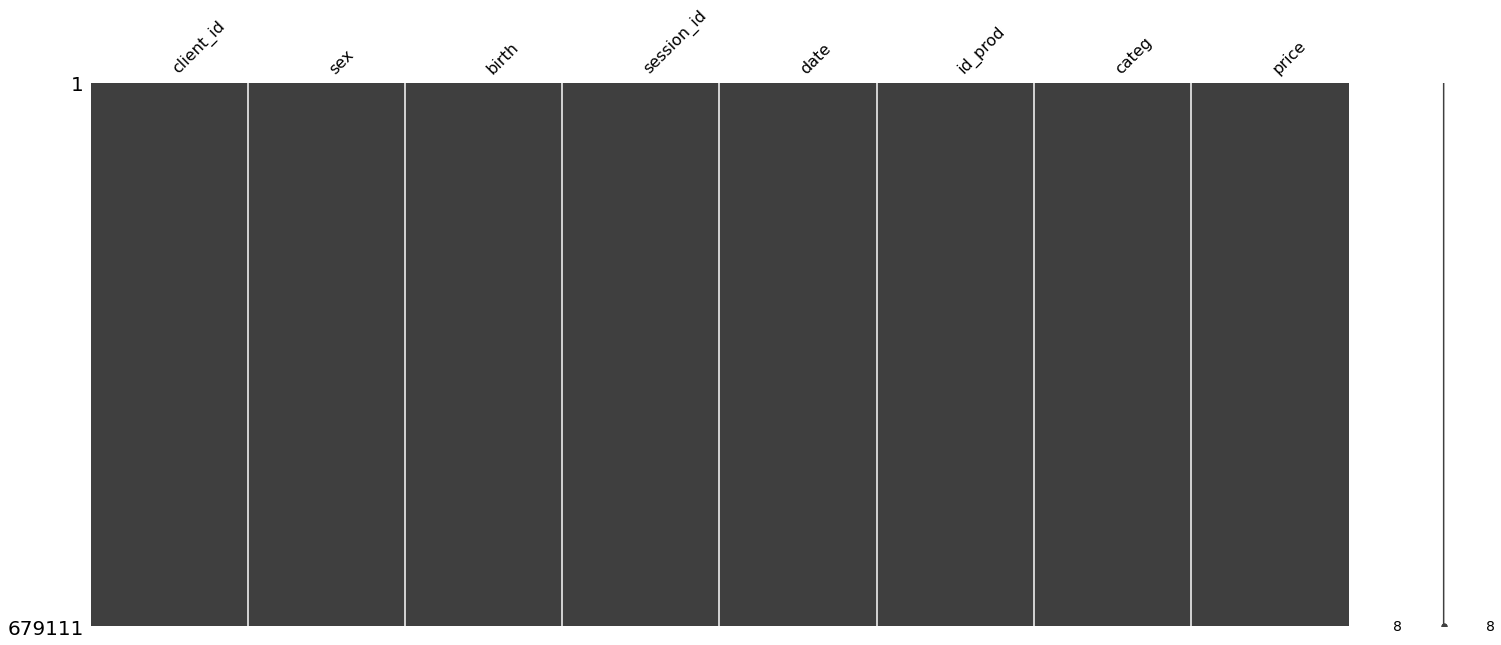

In [67]:
msno.matrix(df_global_ordered)

<AxesSubplot:>

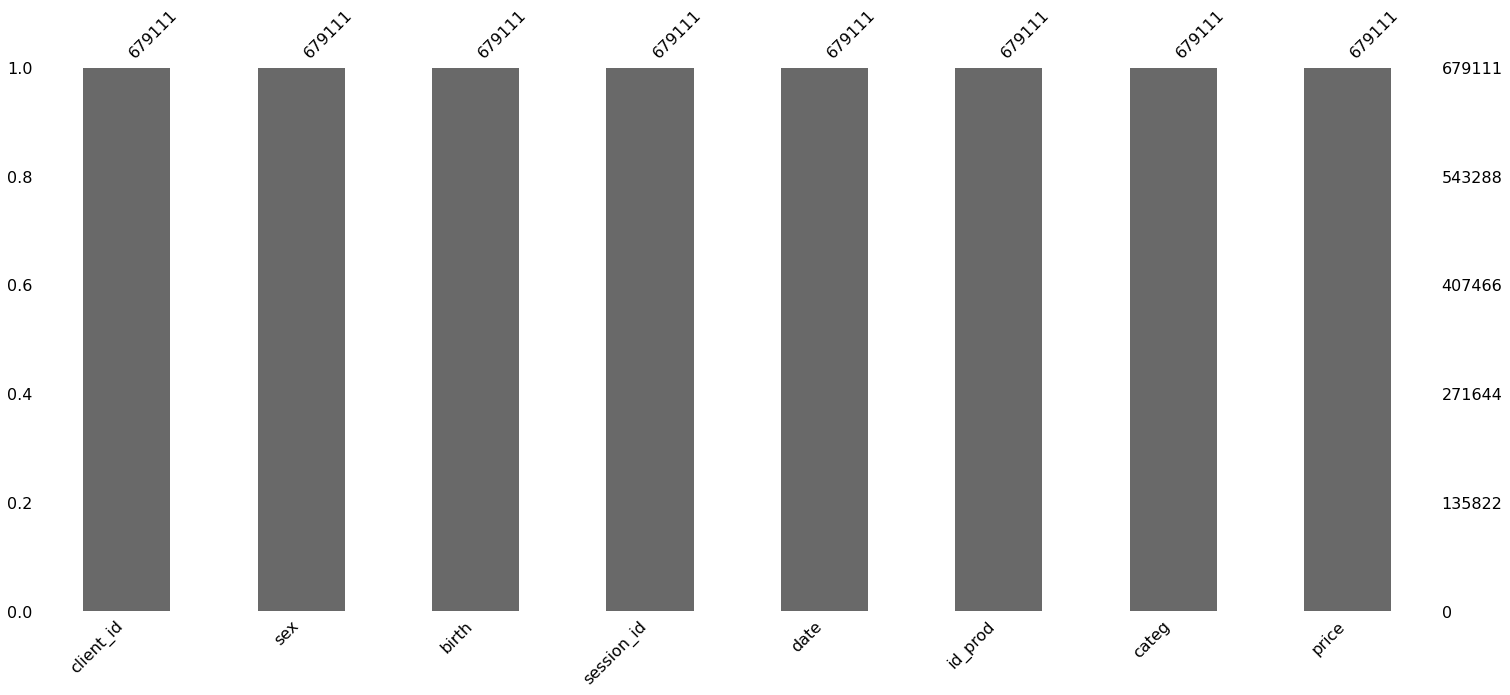

In [68]:
msno.bar(df_global_ordered)

In [69]:
df_global_ordered.describe(include="all")

C:\Users\User\AppData\Local\Temp/ipykernel_4852/1875804349.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_global_ordered.describe(include="all")


,client_id,sex,birth,session_id,date,id_prod,categ,price
count,679111,679111,679111.000000,679111,679111,679111,679111.000000,679111.000000
unique,8600,2,NaN,342275,679111,3265,NaN,NaN
top,c_1609,m,NaN,s_118668,2022-05-20 13:21:29.043970,1_369,NaN,NaN
freq,25488,340826,NaN,14,1,2252,NaN,NaN
first,NaN,NaN,NaN,NaN,2021-03-01 00:01:07.843138,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2023-02-28 23:58:30.792755,NaN,NaN,NaN
mean,NaN,NaN,1977.811149,NaN,NaN,NaN,0.441953,17.454773
std,NaN,NaN,13.575361,NaN,NaN,NaN,0.595042,18.328998
min,NaN,NaN,1929.000000,NaN,NaN,NaN,0.000000,0.620000
25%,NaN,NaN,1970.000000,NaN,NaN,NaN,0.000000,8.870000


In [51]:
df_global_clean["date"].min()

'2021-03-01 00:01:07.843138'

In [52]:
df_global_clean["date"].max()

'2023-02-28 23:58:30.792755'

In [53]:
df_global_clean['month_year'] = pd.to_datetime(df_global_clean['date']).dt.to_period('M')
df_global_clean.head()

,id_prod,date,session_id,client_id,price,categ,_merge,month_year
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,both,2022-05
1,0_1518,2021-09-26 12:37:29.780414,s_95811,c_6197,4.18,0.0,both,2021-09
2,0_1518,2021-05-06 17:14:43.117440,s_30782,c_682,4.18,0.0,both,2021-05
3,0_1518,2022-03-16 18:57:10.420103,s_180057,c_5932,4.18,0.0,both,2022-03
4,0_1518,2022-11-12 18:58:10.574853,s_296584,c_7217,4.18,0.0,both,2022-11


In [54]:
df_global_clean.dtypes

id_prod          object
date             object
session_id       object
client_id        object
price           float64
categ           float64
_merge         category
month_year    period[M]
dtype: object

Regarder les valeurs abérentes et atypique

Note des données à analyser remarquée dans le describe :
- Livre à 300 €
- Client qui apparaît 25488 fois (c_1609)
- Date de session > à la date du jour => non possible...

In [55]:
df_300 = df_global_clean[df_global_clean["price"]==300]
df_300.head(15)

,id_prod,date,session_id,client_id,price,categ,_merge,month_year
670345,2_2,2022-12-07 06:52:26.810576,s_308301,c_4958,300.0,2.0,both,2022-12
670346,2_2,2021-06-12 08:44:00.882917,s_47558,c_5237,300.0,2.0,both,2021-06
670347,2_2,2022-08-12 08:44:00.882917,s_252144,c_5237,300.0,2.0,both,2022-08
670348,2_2,2021-05-02 18:34:47.753888,s_28956,c_2329,300.0,2.0,both,2021-05
670349,2_2,2021-06-06 23:14:33.815188,s_45088,c_2467,300.0,2.0,both,2021-06
670350,2_2,2021-12-07 06:52:26.810576,s_130658,c_4958,300.0,2.0,both,2021-12
670351,2_2,2022-03-28 21:24:28.442508,s_185980,c_659,300.0,2.0,both,2022-03
670352,2_2,2022-02-28 21:24:28.442508,s_172373,c_659,300.0,2.0,both,2022-02
670353,2_2,2022-06-07 06:52:26.810576,s_220074,c_4958,300.0,2.0,both,2022-06
670354,2_2,2022-12-06 23:14:33.815188,s_308128,c_2467,300.0,2.0,both,2022-12


In [56]:
df_300["id_prod"].value_counts()

2_2    15
Name: id_prod, dtype: int64

In [57]:
df_global_clean["id_prod"].value_counts()

1_369     2252
1_417     2189
1_414     2180
1_498     2128
1_425     2096
          ... 
2_23         1
0_1284       1
2_98         1
2_81         1
0_833        1
Name: id_prod, Length: 3265, dtype: int64

In [58]:
top_customer = df_global_clean[df_global_clean["client_id"]=="c_1609"]
top_customer

,id_prod,date,session_id,client_id,price,categ,_merge,month_year
29,0_1518,2022-04-27 17:10:40.102676,s_200245,c_1609,4.18,0.0,both,2022-04
95,0_1518,2021-12-20 04:12:39.844775,s_137046,c_1609,4.18,0.0,both,2021-12
110,0_1518,2023-02-15 15:20:37.281734,s_342011,c_1609,4.18,0.0,both,2023-02
167,0_1518,2021-05-27 17:10:40.102676,s_40318,c_1609,4.18,0.0,both,2021-05
168,0_1518,2021-10-13 18:00:08.691379,s_104281,c_1609,4.18,0.0,both,2021-10
...,...,...,...,...,...,...,...,...
679071,0_1423,2022-02-02 22:55:19.039643,s_159074,c_1609,2.99,0.0,both,2022-02
679195,0_1871,2021-11-01 07:26:17.783922,s_113092,c_1609,1.99,0.0,both,2021-11
679210,0_88,2021-06-11 15:31:20.504586,s_47243,c_1609,8.30,0.0,both,2021-06
679272,0_43,2021-07-24 16:58:56.872277,s_66625,c_1609,2.99,0.0,both,2021-07


In [59]:
top_customer["session_id"].value_counts()

s_332404    9
s_135123    9
s_95564     9
s_302818    9
s_94070     8
           ..
s_90351     1
s_1497      1
s_263015    1
s_330266    1
s_54363     1
Name: session_id, Length: 10997, dtype: int64

In [60]:
df_global_clean["price"].value_counts()

15.99     21361
4.99      18634
10.99     17981
3.99      17351
11.99     16426
          ...  
149.74        1
115.99        1
1.38          1
2.48          1
21.82         1
Name: price, Length: 1442, dtype: int64

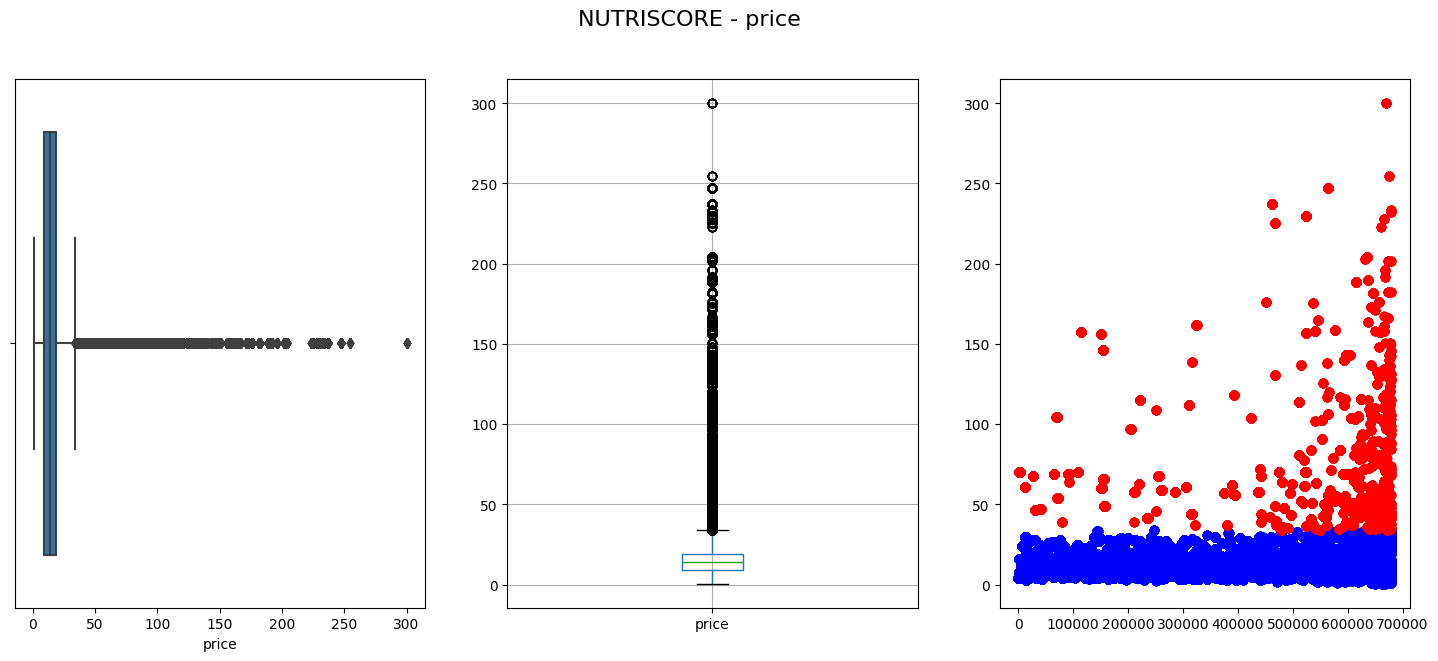

In [61]:
column_name = "price"
q_low, q_hi,iqr, q_min, q_max = functions.get_outliers_datas(df_global_clean, column_name)
functions.graphe_outliers(df_global_clean, column_name, q_min, q_max)

Je décide d'enlever le livre à 300 euros qui est à la marge par rapport aux autres produits

In [62]:
print(df_global_clean.shape)
df_global_ss_outliers = df_global_clean[df_global_clean["price"]<300]
df_global_ss_outliers.shape

(679111, 8)


(679096, 8)

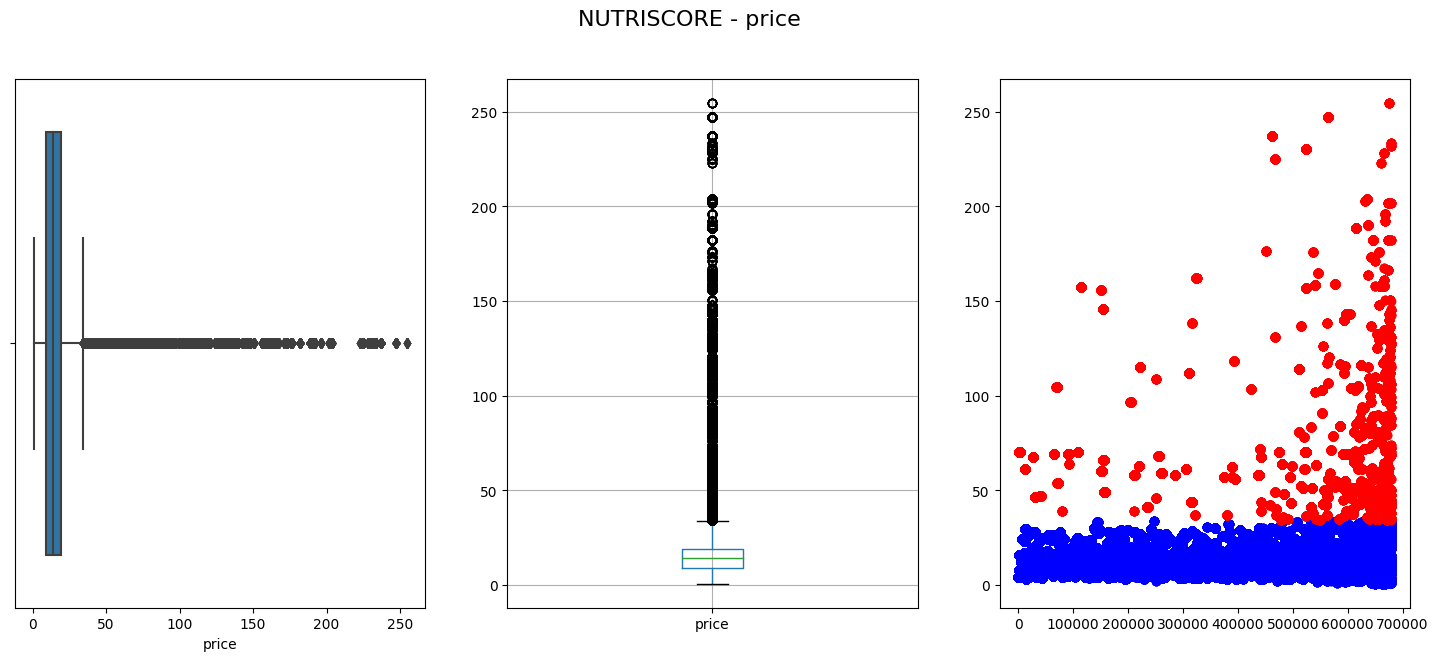

In [63]:
column_name = "price"
q_low, q_hi,iqr, q_min, q_max = functions.get_outliers_datas(df_global_ss_outliers, column_name)
functions.graphe_outliers(df_global_ss_outliers, column_name, q_min, q_max)
# TODO à voir si nécessaire
# Suppression des outliers
# df = df[(df[column] <= q_max) & (df[column] >= q_min)]

In [55]:
df_global_clean.dtypes

date          datetime64[ns]
client_id             object
sex                 category
birth                  int64
session_id            object
id_prod               object
categ               category
price                float64
year                   int64
month                  int64
month_year         period[M]
dtype: object

Suite à l'analyse des données, nous avons constaté que les données sont une prédiction

In [32]:
df_global_clean[(df_global_clean["year"] == 2022) & (df_global_clean["client_id"]=="c_659")].sort_values("date") .head()

,date,client_id,sex,birth,session_id,id_prod,categ,price,year2,year
278395,2022-01-01 01:35:11.135734,c_659,f,2001,s_143146,2_230,2.0,57.04,2022,2022
294400,2022-01-17 13:21:19.828325,c_659,f,2001,s_151160,1_378,1.0,26.61,2022,2022
294432,2022-01-17 14:17:19.953159,c_659,f,2001,s_151160,1_480,1.0,19.08,2022,2022
315945,2022-02-08 23:58:57.465437,c_659,f,2001,s_162179,1_385,1.0,25.99,2022,2022
315948,2022-02-09 00:06:37.558681,c_659,f,2001,s_162179,2_237,2.0,40.99,2022,2022


In [34]:
df_global_clean[(df_global_clean["year"] == 2022) & (df_global_clean["client_id"]=="c_659")].sort_values("date").shape

(43, 10)

In [39]:
df_global_clean[(df_global_clean["year"] <2021) & (df_global_clean["client_id"]=="c_659")].sort_values("date").shape

(0, 10)

In [35]:
df_global_clean[(df_global_clean["year"] ==2021) & (df_global_clean["client_id"]=="c_659")].sort_values("date").shape

(29, 10)

In [36]:
df_global_clean[(df_global_clean["year"] ==2021) & (df_global_clean["client_id"]=="c_659")].sort_values("date") .head()

,date,client_id,sex,birth,session_id,id_prod,categ,price,year2,year
5798,2021-03-07 04:54:33.733375,c_659,f,2001,s_2885,2_26,2.0,42.51,2021,2021
17737,2021-03-20 03:31:41.128928,c_659,f,2001,s_8799,0_1480,0.0,4.15,2021,2021
17743,2021-03-20 03:39:24.646901,c_659,f,2001,s_8799,1_457,1.0,22.99,2021,2021
17746,2021-03-20 03:41:29.034120,c_659,f,2001,s_8799,1_358,1.0,17.24,2021,2021
17748,2021-03-20 03:44:44.336385,c_659,f,2001,s_8799,1_413,1.0,17.99,2021,2021


## 1. Une analyse des indicateurs de vente
1. Chiffre d'affaire : indicateurs et graphiques
1. Chiffre d'affaire : évolution dans le temps
1. Chiffre d'affaire : décomposition en moyenne mobile pour évaluer la tendance globale
1. Chiffre d'affaire : par référence
1. Chiffre d'affaire : par référence - Tops et Flops
1. Chiffre d'affaire : par catégorie
1. Profils client
1. Chiffre d'affaire par profil client - Courbe de Lorenz


In [57]:
df_global_clean.describe(include="all")

C:\Users\User\AppData\Local\Temp/ipykernel_9808/2002573402.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_global_clean.describe(include="all")


,date,client_id,sex,birth,session_id,id_prod,categ,price,year,month,month_year
count,679111,679111,679111,679111.000000,679111,679111,679111.0,679111.000000,679111.000000,679111.000000,679111
unique,679111,8600,2,NaN,342275,3265,3.0,NaN,NaN,NaN,24
top,2021-03-01 00:01:07.843138,c_1609,m,NaN,s_118668,1_369,0.0,NaN,NaN,NaN,2021-09
freq,1,25488,340826,NaN,14,2252,415459.0,NaN,NaN,NaN,33314
first,2021-03-01 00:01:07.843138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-02-28 23:58:30.792755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1977.811149,NaN,NaN,NaN,17.454773,2021.670503,6.504383,NaN
std,NaN,NaN,NaN,13.575361,NaN,NaN,NaN,18.328998,0.617562,3.480774,NaN
min,NaN,NaN,NaN,1929.000000,NaN,NaN,NaN,0.620000,2021.000000,1.000000,NaN
25%,NaN,NaN,NaN,1970.000000,NaN,NaN,NaN,8.870000,2021.000000,3.000000,NaN


## 1. Une analyse des indicateurs de vente
1. Chiffre d'affaire : indicateurs et graphiques
1. Chiffre d'affaire : évolution dans le temps
1. Chiffre d'affaire : décomposition en moyenne mobile pour évaluer la tendance globale
1. Chiffre d'affaire : par référence
1. Chiffre d'affaire : par référence - Tops et Flops
1. Chiffre d'affaire : par catégorie
1. Profils client
1. Chiffre d'affaire par profil client - Courbe de Lorenz


Evolution du chiffre d'affaire

In [58]:
# Evolution du chiffre d'affaire
df_ca = df_global_clean.groupby('month_year', as_index=False)['price'].sum()
df_ca.head(20)


,month_year,price
0,2021-03,482440.61
1,2021-04,476109.30
2,2021-05,492943.47
3,2021-06,484088.56
4,2021-07,482835.40
5,2021-08,482284.79
6,2021-09,507240.68
7,2021-10,320798.74
8,2021-11,516167.73
9,2021-12,525917.28


## 2. Une analyse des clients

Comprendre le comportement des clients en ligne
Comparaison avec le comportement des cliens en librairie

1. Genre d'un client et catégorie de livre acheté
1. Age d'un client et montant total des achats, fréquance d'achat, taille du panier moyen, catégorie de livre acheté
